In [1]:
import logging
import config

from IPython import display
from dataset.TPL import *
import dataset.preprocessing as pre

import numpy as np
import pandas as pd
import time
import pickle
import ftn
# from pprint import pprint
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
%reload_ext autoreload
%autoreload 2
logging.basicConfig(level=logging.INFO)

/Users/jgil/ESO/SM2022/ldamodel/venv/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


### LDA SKL MODEL- Matisse

#### 1) Import Data:

In [2]:
#---------------------------#
#Importamos la data:
matisse1=TplMatisse(config=config.ds_medium)
# Some rows are small (<5 sec) or unbounded (>30m), this criteria will restrict to only the good ones
matisse1.index = matisse1.index[matisse1.index["SECONDS"] > 5]
matisse1.index = matisse1.index[matisse1.index["SECONDS"] < 1800]

#### 2) Data Preprocessing:

In [3]:
%%time
#---------------------------#
#Aplicamos la función:
matisse_SES=ftn.generate_serie_SES(matisse1)

CPU times: user 1min 9s, sys: 3.82 s, total: 1min 13s
Wall time: 1min 21s


In [47]:
#result=open("matisse_SES","wb")
#pickle.dump(matisse_SES,result)
#result.close()

In [34]:
#---------------------------------------#
#First load ()
matisse_SES=pickle.load(open("matisse_SES","rb"))

In [35]:
#Separamos la train_data de la test_data
#----------------------------#
matisse_train,matisse_test=ftn.traintestdata(matisse_SES,0.2)

In [36]:
#Creamos la matriz toke-frequency para nuestra data de entrenamiento:
#----------------------------------------#
info_train_v, v= ftn.vectorizer(matisse_train)
print('Numéro de traces: ',info_train_v.shape[0])
print('Número de tokens: ',info_train_v.shape[1])
#Show vocab v: class countvectorizer()
#v.vocabulary_
#Show vocab in alphabetical order
#v.get_feature_names()

Numéro de traces:  944
Número de tokens:  64619


**3) LDA optimal model:**

In [37]:
%%time
# Define Search Param
search_params = {'n_components': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda_opt = LatentDirichletAllocation(max_iter=10)

# Init Grid Search Class
model = GridSearchCV(lda_opt, param_grid=search_params)

# Do the Grid Search
model.fit(info_train_v)

CPU times: total: 22min 54s
Wall time: 22min 27s


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15]})

In [38]:
#Best model
bestldamodel = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", bestldamodel.perplexity(info_train_v))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -1248368.1590399467
Model Perplexity:  357.96693266814754


In [46]:
#result=open("matisse_optimalmodel","wb")
#pickle.dump(bestldamodel,result)
#result.close()

In [15]:
#---------------------------------------#
#Second load ()
bestldamodel=pickle.load(open("matisse_optimalmodel","rb"))

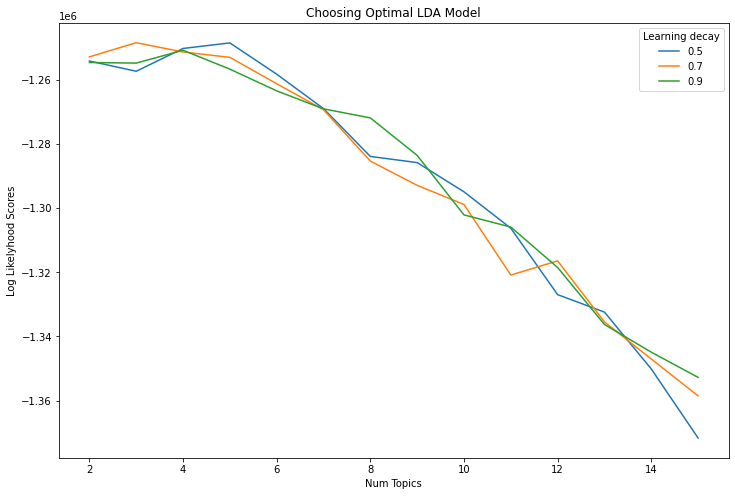

In [39]:
# Get Log Likelyhoods from Grid Search Output
log_likelyhoods_5 = []
log_likelyhoods_7 = []
log_likelyhoods_9 = []
n_topics=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for i in range(len(model.cv_results_['params'])):
    if model.cv_results_['params'][i]['learning_decay'] == 0.5:
       log_likelyhoods_5.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.7:
       log_likelyhoods_7.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.9:
       log_likelyhoods_9.append(round(model.cv_results_['mean_test_score'][i]))

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


In [49]:
model.cv_results_

{'mean_fit_time': array([3.61167407, 4.57350607, 4.75035725, 5.20652595, 5.36368618,
        5.23870759, 5.40520697, 6.06158648, 6.0443161 , 7.12713771,
        7.19403534, 7.50292406, 7.75603352, 8.20267611, 4.16266441,
        4.70360694, 5.33755212, 5.33938856, 4.88756604, 5.70157499,
        6.32092566, 6.73097291, 6.50175724, 8.5239316 , 7.08425283,
        8.67854304, 9.21771946, 9.07585702, 4.11056085, 4.58250799,
        4.7133059 , 5.46916776, 5.19113712, 5.76409736, 5.41444182,
        5.91091666, 6.4564405 , 7.01235142, 6.16621437, 7.8116148 ,
        7.11857548, 7.55808892]),
 'std_fit_time': array([0.63675609, 0.36505652, 0.34207018, 0.40816122, 0.25149956,
        0.15794636, 0.56085682, 0.72808955, 0.61658237, 0.59357279,
        0.64051307, 0.6961462 , 0.85765782, 1.09304989, 1.36515886,
        0.68376727, 0.48152134, 0.90878838, 0.63904489, 0.50625871,
        0.45578509, 0.33717328, 0.69991482, 1.72930074, 0.50436544,
        1.16199938, 1.69761489, 0.81160116, 1.074

In [40]:

#le entregamos nuestra matriz token-frequency creada anteriormente
bestldamodel.fit(info_train_v)

# making LDA TOP MATRIX USING CORPUS TF
lda_topic_modelling = bestldamodel.fit_transform(info_train_v)

In [42]:
#------------------------------------------------#
#Dejamos todo como str (la info contiene números)
matisse_SES=matisse_SES.apply(str)

#Aplicamos el CV
matisse_SES_v = v.transform(matisse_SES)

In [43]:
#----------------------------------------------------#
#Mostramos la contribución de los tópicos a cada una de las traces:
df_topic_dc=ftn.topic_document(bestldamodel,matisse_SES_v)
df_topic_dc

,0,1,2
0,0.998527,0.000714,0.000760
1,0.999649,0.000171,0.000180
2,0.999604,0.000192,0.000204
3,0.996079,0.001926,0.001995
4,0.999141,0.000421,0.000438
...,...,...,...
1175,0.999594,0.000197,0.000209
1176,0.998631,0.000668,0.000702
1177,0.997449,0.001236,0.001315
1178,0.998720,0.000620,0.000659


### 4) Results:

In [44]:
#--------------------------------------------------------#
final_df=ftn.final_result(matisse1.index,bestldamodel,matisse_SES_v)
final_df[:30]

,Num trace,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,estimated (s),real (s),diff (s),SECONDS,0,1,2
0,0,2020-12-03 22:28:21.278000+00:00,2020-12-03 22:54:02.577000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_ali,False,False,1020,2541,921,1541.0,0.998527,0.000714,0.000760
1,1,2020-12-03 22:59:52.185000+00:00,2020-12-03 23:11:34.211000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_ali,False,False,1020,1142,82,702.0,0.999649,0.000171,0.000180
2,2,2020-12-04 18:12:58.130000+00:00,2020-12-04 18:33:35.254000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_ali,False,False,900,2037,697,1237.0,0.999604,0.000192,0.000204
3,3,2020-12-04 18:34:19.053000+00:00,2020-12-04 18:34:57.750000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_ali,False,False,900,38,502,38.0,0.996079,0.001926,0.001995
4,5,2020-12-04 18:37:24.312000+00:00,2020-12-04 18:41:29.024000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_opd,False,False,320,405,45,244.0,0.999141,0.000421,0.000438
5,6,2020-12-04 18:41:29.057000+00:00,2020-12-04 18:43:20.410000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_opd,False,False,320,151,89,111.0,0.998431,0.000761,0.000808
6,7,2020-12-04 18:43:20.443000+00:00,2020-12-04 18:44:24.728000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_opd,False,False,130,104,26,64.0,0.998168,0.000889,0.000943
7,8,2020-12-04 18:44:24.771000+00:00,2020-12-04 18:47:06.517000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_opd,False,False,320,242,38,161.0,0.998444,0.000750,0.000806
8,9,2020-12-04 18:47:06.553000+00:00,2020-12-04 18:48:58.064000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_opd,False,False,320,152,88,111.0,0.998407,0.000773,0.000820
9,10,2020-12-04 18:48:58.097000+00:00,2020-12-04 18:50:09.133000+00:00,False,MATISSE,bob_ins,MATISSE_gen_tec_opd,False,False,130,111,19,71.0,0.998182,0.000882,0.000936


In [20]:
#--------------------------------------#
#result=open("matisse_result","wb")
#pickle.dump(final_df,result)
#result.close()

In [21]:
#---------------------------------------#
final_result=pickle.load(open("matisse_result","rb"))

## 5=) Topic Words

In [45]:
topic_words=ftn.show_topics(vect_class=v,lda_model=bestldamodel, n_words=20)
topic_words.T

,Topic 0,Topic 1,Topic 2
Word 0,"'{}_(SpringGreen4)',",'ccsScheduler:_Process_<isllogMonitorDb_-cfg_m...,'WARNING:_new_header_block_is_added_to_the_FIT...
Word 1,"'Executing_SETUP_command_...',","'{}_(SpringGreen4)',","'{}_(SpringGreen4)',"
Word 2,"'SETUP_command_done.',","'Executing_SETUP_command_...',","'Executing_SETUP_command_...',"
Word 3,"'Forward(b)_SETUP_to_NGCIR1',","'SETUP_command_done.',","'SETUP_command_done.',"
Word 4,"'Forward(b)_SETUP_to_NGCIR2',","'Forward(b)_SETUP_to_NGCIR1',","'Forward(b)_SETUP_to_NGCIR2',"
Word 5,"'Reply_to_wait_cmd_arrived',","""mtnrtsERR_WRONG_REGION_INDEX_:_Region_index_'...","'Forward(b)_SETUP_to_NGCIR1',"
Word 6,'SETUP_-expoId_{}_-function_INS.MODE_AUTOTEST_...,"'Forward(b)_SETUP_to_NGCIR2',",'SETUP_-expoId_{}_-function_INS.MODE_HYBRID_(b...
Word 7,"""Last_Reply_to_'EXPEND'_from_'ICS'_received:_'...","'OPD_beam_{}_=_{}_um',","'Reply_to_wait_cmd_arrived',"
Word 8,"'Executing_START_command_...',","'Reply_to_wait_cmd_arrived',","'Send_command_\'EXPSTRT\'_\'""NGCIR1_NGCIR2_VLT..."
Word 9,'starting_exposure_{}_of_{}_({})_..._(underlin...,'SETUP_-expoId_{}_-function_INS.MODE_AUTOTEST_...,"'Send_command_\'EXPEND\'_\'""NGCIR1_NGCIR2_VLTI..."
